In [2]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from geopy.geocoders import Nominatim
import time

sns.set_style('white')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (16, 9),
          'axes.labelsize': 'medium',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'small',
          'ytick.labelsize':'small',
          'legend.loc': 'upper right'}

pylab.rcParams.update(params)


%matplotlib inline

In [3]:
connection1 = sqlite3.connect('AquablissData/everywhere.db')
connection2 = sqlite3.connect('AquablissData/frensham.db')
connection3 = sqlite3.connect('AquablissData/sevenhills.db')

everywhere_sessions = pd.read_csv('Datasets/sessions.csv', index_col=0)
everywhere_session_students = pd.read_csv('Datasets/sessionstudents.csv', index_col=0)

/Users/stefano/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
everywhere_sessions['start_time'] = pd.to_datetime(everywhere_sessions.start_time)
everywhere_sessions['end_time'] = pd.to_datetime(everywhere_sessions.end_time)
everywhere_sessions['date'] = everywhere_sessions.start_time.dt.date

when_students_were_supposed_to_come = everywhere_sessions.merge(everywhere_session_students,
                         left_on='session_id', right_on='session_id')[['date','student_id', 'session_id']]

when_students_were_supposed_to_come.head()

,date,student_id,session_id
0,2006-10-16,70,25
1,2006-10-16,71,25
2,2006-10-16,74,25
3,2006-10-16,463,26
4,2006-10-16,467,26


## no Addresses in the database so I manually add it! 

In [5]:
Addresses = pd.DataFrame.from_dict({'WENONA':['201-203 Walker Street, North Sydney NSW', '2060'],
                                    'NORMANHURST':['91-93 Pennant Hills Road, Normanhurst NSW', '2076'],
                                    'PYMBLE':['1 Bobbin Head Road, Pymble NSW', '2073'],
                                    'THORNLEIGH':['17 Sefton Road, Thornleigh NSW', '2120'],
                                    'FRENSHAM':['Range Road, Mittagong NSW', '2575'],
                                    'SEVEN HILLS':['20 Distribution Place, Seven Hills NSW', '2575'],
                                    'WERRINGTON':['Unit 2/1 Lavin Crescent, Werrington County NSW', '2747'],
                                    'ROSEVILLE':['27 Bancroft Avenue, Roseville NSW', '2069'],
                                    'GREGORY HILLS':['67-77 Lasso Road, Gregory Hills NSW', '2069']
                                   }, orient = 'index').reset_index()

Addresses.rename(columns ={'index':'LocationName', 0:'LocationAddress', 1:'PostCode'},inplace=True)

Addresses

,LocationName,LocationAddress,PostCode
0,THORNLEIGH,"17 Sefton Road, Thornleigh NSW",2120
1,WERRINGTON,"Unit 2/1 Lavin Crescent, Werrington County NSW",2747
2,ROSEVILLE,"27 Bancroft Avenue, Roseville NSW",2069
3,GREGORY HILLS,"67-77 Lasso Road, Gregory Hills NSW",2069
4,WENONA,"201-203 Walker Street, North Sydney NSW",2060
5,NORMANHURST,"91-93 Pennant Hills Road, Normanhurst NSW",2076
6,PYMBLE,"1 Bobbin Head Road, Pymble NSW",2073
7,SEVEN HILLS,"20 Distribution Place, Seven Hills NSW",2575
8,FRENSHAM,"Range Road, Mittagong NSW",2575


## Creating the locaiton DF form the Locations SQL Tables and and the addresses

In [6]:

Locations = pd.concat([pd.read_sql('select LocationName, Name as AccessPointName, LocationId from AccessPoints, Locations where AccessPoints.LocationId = Locations.Id', 
                                   con=connection1),
                       pd.read_sql('select LocationName, Name as AccessPointName, LocationId from AccessPoints, Locations where AccessPoints.LocationId = Locations.Id', 
                                   con=connection2).replace({'Loc1':'FRENSHAM',1:5}),
                       pd.read_sql('select LocationName, Name as AccessPointName, LocationId from AccessPoints, Locations where AccessPoints.LocationId = Locations.Id', 
                                   con=connection3).replace({'Loc1':'SEVEN HILLS',1:6}),
                     ])

Locations = Locations.merge(Addresses, on='LocationName')

Locations.sort_values('LocationId')

,LocationName,AccessPointName,LocationId,LocationAddress,PostCode
0,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076
1,NORMANHURST,NHRECEPTION,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076
2,NORMANHURST,NHSUPERVISOR,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076
3,THORNLEIGH,THSERVER,2,"17 Sefton Road, Thornleigh NSW",2120
4,THORNLEIGH,THADMIN,2,"17 Sefton Road, Thornleigh NSW",2120
5,THORNLEIGH,THRECEPTION,2,"17 Sefton Road, Thornleigh NSW",2120
6,PYMBLE,PBADMIN,3,"1 Bobbin Head Road, Pymble NSW",2073
7,PYMBLE,PBRECEPTION,3,"1 Bobbin Head Road, Pymble NSW",2073
8,PYMBLE,PBSUPERVISOR,3,"1 Bobbin Head Road, Pymble NSW",2073
9,WENONA,WNADMIN,4,"201-203 Walker Street, North Sydney NSW",2060


In [7]:
# what the hell is this AccessPointId 0 ??? 
# ID 0 no entry location or entrypoint name! I cannot reconnnected with any swimmingpool
# only 5371 row out of 341268 rows returned in 404ms from: select * from AccessPointEntries

print pd.read_sql('select * from AccessPointEntries  where AccessPointEntries.AccessPointId = 0',
                     con=connection1).shape

# Unfortunatelly I had to change the datapase of Seven Hills since the AccessPointEntries wheren't correct, 
# 0-1 insead of 1-2 plus still non corect but not relevant

# UPDATE table_name SET column1 = value1, column2 = value2...., columnN = valueN WHERE [condition]


(5371, 26)


In [8]:

Entries1 = pd.read_sql('select * from AccessPoints, AccessPointEntries where AccessPoints.Id = AccessPointEntries.AccessPointId', 
                       con=connection1)

Entries2 = pd.read_sql('select * from AccessPoints, AccessPointEntries where AccessPoints.Id = AccessPointEntries.AccessPointId', 
                       con=connection2)

Entries3 = pd.read_sql('select * from AccessPoints, AccessPointEntries where AccessPoints.Id = AccessPointEntries.AccessPointId', 
                       con=connection3)

# Replece the erroneus Loc1 LocationId 1
Entries2.LocationId = Entries2.LocationId.replace(1,5)
Entries3.LocationId = Entries3.LocationId.replace(1,6)

# Concatenate the three dataframes
Entries = pd.concat([Entries1, Entries2, Entries3])

Entries

,Id,Name,Description,MenOnly,WomenOnly,SaveVisit,AccessProfileId,_New,AccessControllerId,CentreAccess,...,AccessServiceProductID,IsStaff,IsGuestPass,ReciprocalId,Errors,Warnings,Messages,EntryCode,Site,IsCustomerOverride
0,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAdult Lap Swimming 10 ...,1382,,0
1,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAdult Lap Swimming 10 ...,7217,,0
2,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,"Visit for CHAUNCY, AIDAN OK\r\nLevel 1 class a...",3716,,0
3,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,"Visit for SORKOVSKY, TARA OK\r\nLevel 1 class ...",8376,,0
4,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,This is a make up lesson.\r\n,"Visit for CHAN, DAVID OK\r\nLevel 3 class at C...",8899,,0
5,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,This is a make up lesson.This family owes $6.0...,"Visit for FLAHERTY, EMMA OK\r\nLevel 3 class a...",4869,,0
6,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,"Visit for PRINCE, MAX OK\r\nLevel 3 class at C...",7660,,0
7,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,"Visit for CHAUNCY, PATRICK OK\r\nLevel 4 class...",3717,,0
8,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,"Visit for LEE, ISABELLA OK\r\nLevel 4 class at...",7528,,0
9,2,NHRECEPTION,Normanhurst Reception,0,0,1,0,203,0,1,...,0,0,0,0,,,"Visit for MORAN, JONATHAN OK\r\nLevel 4 class ...",517,,0


## Creating my entry dataframe with corretct locations

In [9]:

DF = pd.merge(Locations,Entries, how='outer', left_on=['AccessPointName','LocationId'], right_on=['Name','LocationId']).drop(['Name'],axis=1)

DF = DF.rename(columns = {'Id':'AccessPointId'})

DF

,LocationName,AccessPointName,LocationId,LocationAddress,PostCode,AccessPointId,Description,MenOnly,WomenOnly,SaveVisit,...,AccessServiceProductID,IsStaff,IsGuestPass,ReciprocalId,Errors,Warnings,Messages,EntryCode,Site,IsCustomerOverride
0,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAqua Aerobics 10 Visit...,24055,,0
1,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAqua Aerobics 10 Visit...,1435,,0
2,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAqua Aerobics 10 Visit...,12752,,0
3,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAqua Aerobics 10 Visit...,14684,,0
4,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAqua Aerobics 10 Visit...,24513,,0
5,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,"Sorry, could not find a valid reason for visit...",,\r\nMessage sent on 28/11/2014 10:44:44 AM by ...,23028,,0
6,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,"Sorry, could not find a valid reason for visit...",,,20277,,0
7,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,"Sorry, could not find a valid reason for visit...",,,20277,,0
8,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,,This was the last visit for this Visit Pass,Visit pass entry OK\r\nAqua Aerobics 10 Visits,31696,,0
9,NORMANHURST,NHADMIN,1,"91-93 Pennant Hills Road, Normanhurst NSW",2076,1,Normanhurst Administration,0,0,1,...,0,0,0,0,,,Visit pass entry OK \r\nAqua Aerobics 10 Visit...,36189,,0


## Parsing the access as datetime!

In [10]:
DF['AccessTime'] = pd.to_datetime(DF.AccessTime) 

DF.AccessTime.head()

0   2015-06-22 12:48:49
1   2015-06-22 12:49:03
2   2015-06-22 12:49:16
3   2015-06-22 12:49:31
4   2015-06-22 12:50:08
Name: AccessTime, dtype: datetime64[ns]

In [11]:

DF['AccessTIME'] = DF.AccessTime.dt.strftime('%H:%M')
DF['AccessDate'] = pd.to_datetime(DF.AccessTime.dt.date)

DF['AccessDay'] = DF.AccessTime.dt.weekday_name
DF['AccessWeek'] = DF.AccessTime.dt.weekofyear

DF['AccessMonth'] = DF.AccessTime.dt.month
DF['AccessYear'] = DF.AccessTime.dt.year


DF[['AccessDay', 'AccessWeek', 'AccessMonth', 'AccessYear', 'AccessTIME', 'AccessDate', 'AccessTime']].head()


,AccessDay,AccessWeek,AccessMonth,AccessYear,AccessTIME,AccessDate,AccessTime
0,Monday,26,6,2015,12:48,2015-06-22,2015-06-22 12:48:49
1,Monday,26,6,2015,12:49,2015-06-22,2015-06-22 12:49:03
2,Monday,26,6,2015,12:49,2015-06-22,2015-06-22 12:49:16
3,Monday,26,6,2015,12:49,2015-06-22,2015-06-22 12:49:31
4,Monday,26,6,2015,12:50,2015-06-22,2015-06-22 12:50:08


In [12]:
# Checking if Lesson Booking information are correct in my DF comparing it with when_students_were_supposed_to_come dataset

df2 = DF.merge(when_students_were_supposed_to_come, left_on=['PeopleId', 'AccessDate'], 
               right_on=['student_id', 'date'], how='left') 

# df2[['session_id', 'student_id', 'LessonBooking1']].head()

# LessonBooking1 == 0 peapole without lesson

---
# SWIMMINGPOLL
---

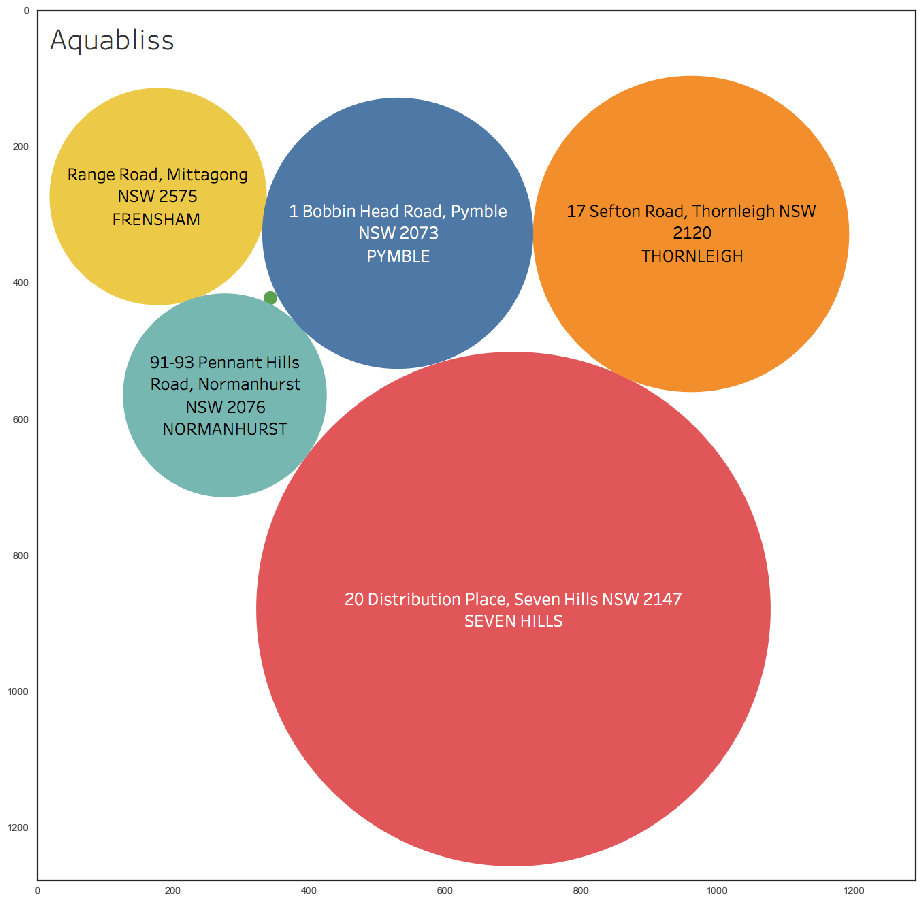

In [13]:
image = img.imread('Datasets/image1.png')
plt.figure(figsize = (16,16))
plt.imshow(image)

---
# TIME of the Day
---

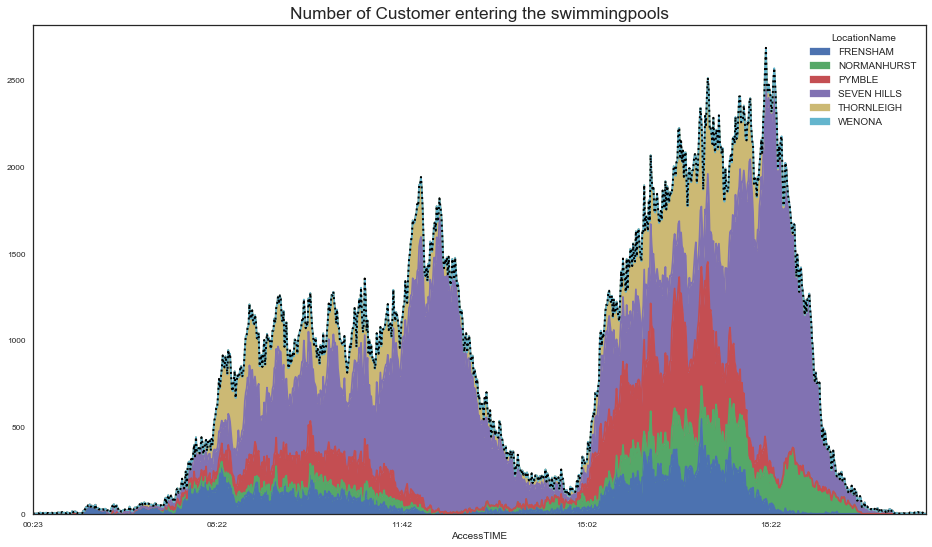

In [45]:
# Time of the Day grouping

pd.pivot_table(DF, index='AccessTIME', columns='LocationName',
               values='IsGuestPass', aggfunc='count',fill_value=0).plot.area(figsize=(16,9))


DF.groupby(('AccessTIME')).IsGuestPass.count().plot(c='black',lw=2, ls=':', title='Number of Customer entering the swimmingpools')
                    


In [30]:
weekdays = DF[DF.AccessDay.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]
saturday = DF[DF.AccessDay == 'Saturday']
sunday = DF[DF.AccessDay == 'Sunday']

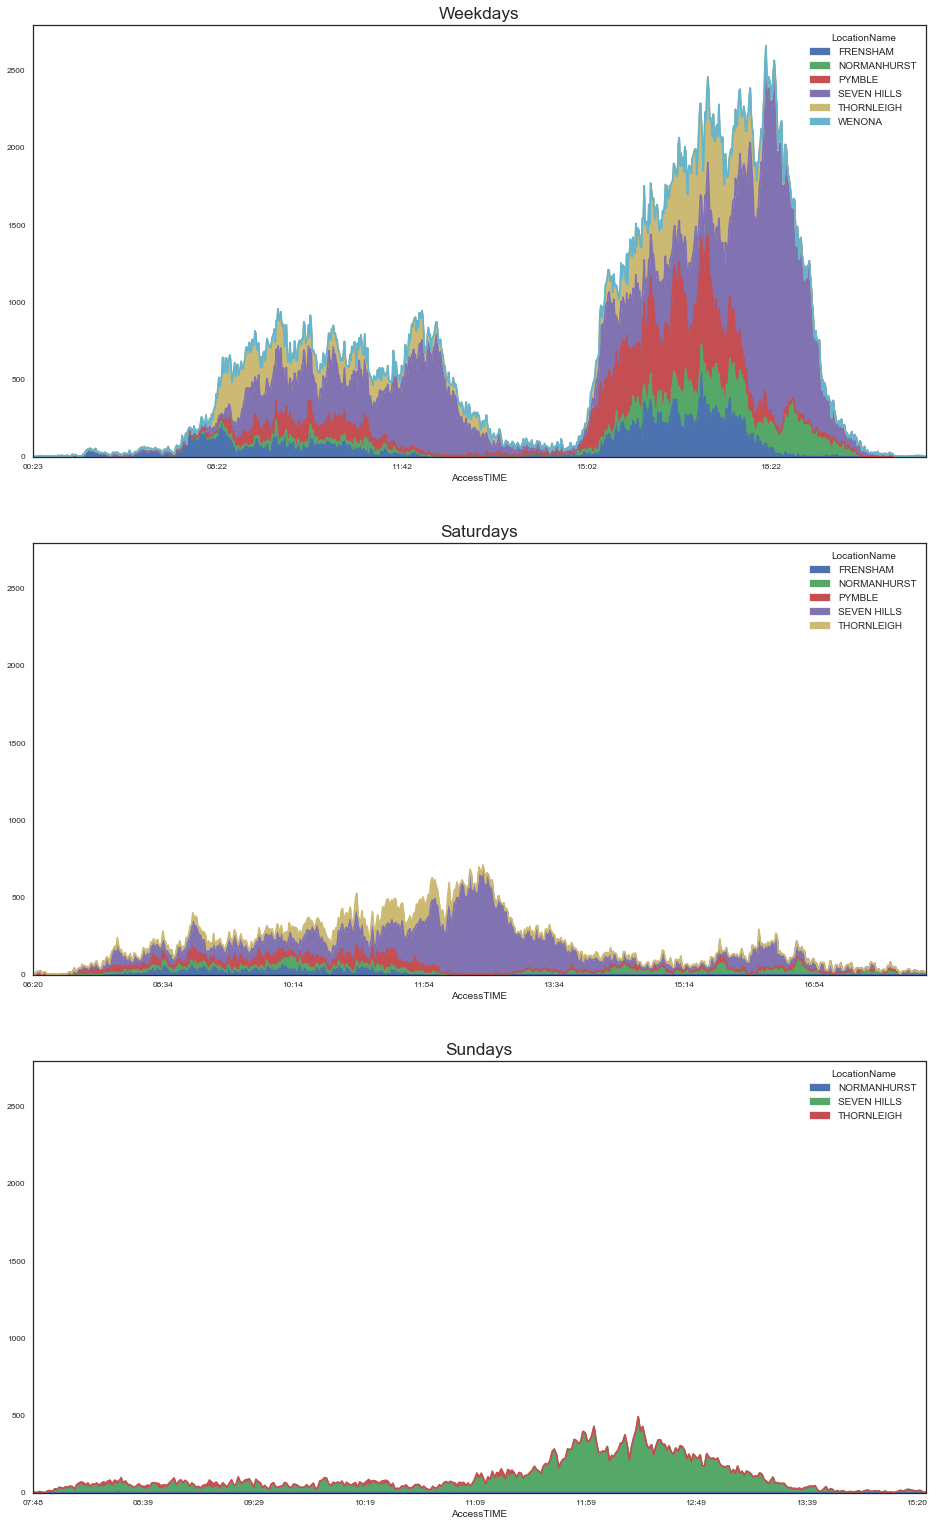

In [48]:
fig,ax = plt.subplots(nrows=3, figsize=(16,9*3),sharey=True)

pd.pivot_table(weekdays, index='AccessTIME', columns='LocationName', 
               values='IsGuestPass', aggfunc='count', fill_value=0).plot.area(ax=ax[0], title='Weekdays')

pd.pivot_table(saturday, index='AccessTIME', columns='LocationName', 
               values='IsGuestPass', aggfunc='count', fill_value=0).plot.area(ax=ax[1], title='Saturdays')

pd.pivot_table(sunday, index='AccessTIME', columns='LocationName', 
               values='IsGuestPass', aggfunc='count', fill_value=0).plot.area(ax=ax[2], title='Sundays')



---
# DAY OF THE WEEK
---

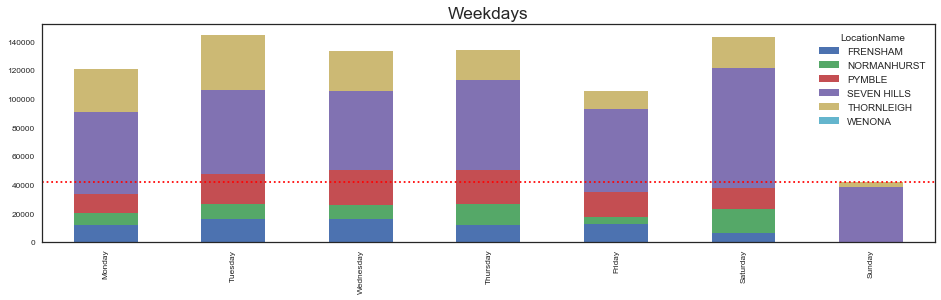

In [233]:
# Grouping DAY OF THE WEEK


WeekDAYs = pd.pivot_table(DF, index='AccessDay', columns='LocationName',
               values='IsGuestPass', aggfunc='count',fill_value=0)

WeekDAYs.index = pd.Categorical(WeekDAYs.index, ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


WeekDAYs = WeekDAYs.sort_index()

plt.figure()

WeekDAYs.plot.bar(figsize=(16,4), stacked=True, title= 'Weekdays')

plt.axhline(y=41640, xmin=0, xmax=1, linestyle='dotted', c='r', hold=None)


In [240]:
WeekDAYs.pct_change().T.mean() # drop day by day

Monday            NaN
Tuesday      0.165048
Wednesday    0.149588
Thursday     0.131605
Friday      -0.388282
Saturday     0.401615
Sunday      -0.875997
dtype: float64

---

# WEEKLY

---

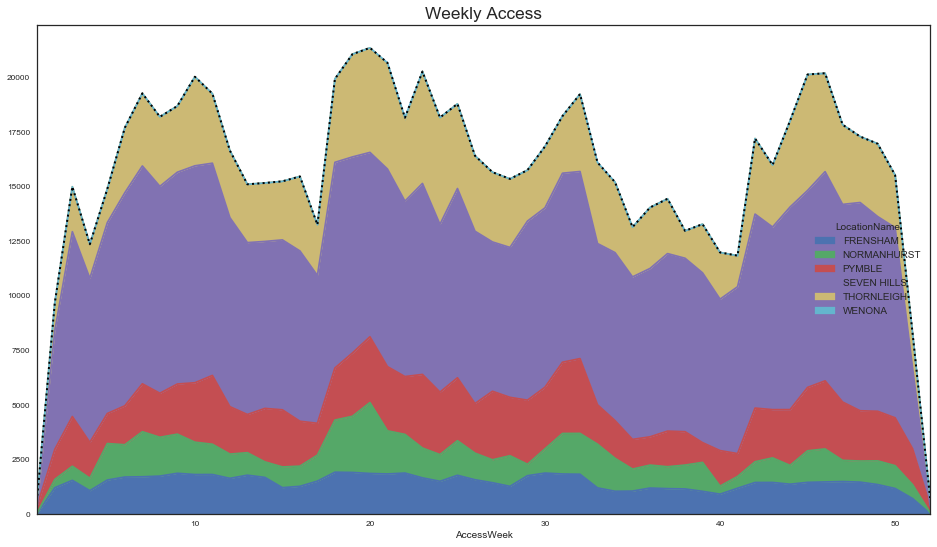

In [324]:
# Weekly grouping

weekly = pd.pivot_table(DF, index='AccessWeek', columns='LocationName',
               values='IsGuestPass', aggfunc='count',fill_value=0)

weekly.plot.area(figsize=(16,9), title='Weekly Access')


DF.groupby(('AccessWeek')).IsGuestPass.count().plot(c='black',lw=2, ls=':')

In [297]:
weekly.sum()

LocationName
FRENSHAM        73634
NORMANHURST     64858
PYMBLE         114669
SEVEN HILLS    412911
THORNLEIGH     156074
WENONA            296
dtype: int64

In [245]:
weekly.T.sum().describe()

count       52.000000
mean     15816.192308
std       4185.674013
min        719.000000
25%      14757.500000
50%      16232.000000
75%      18317.000000
max      21323.000000
dtype: float64

---
# MONTHLY
---

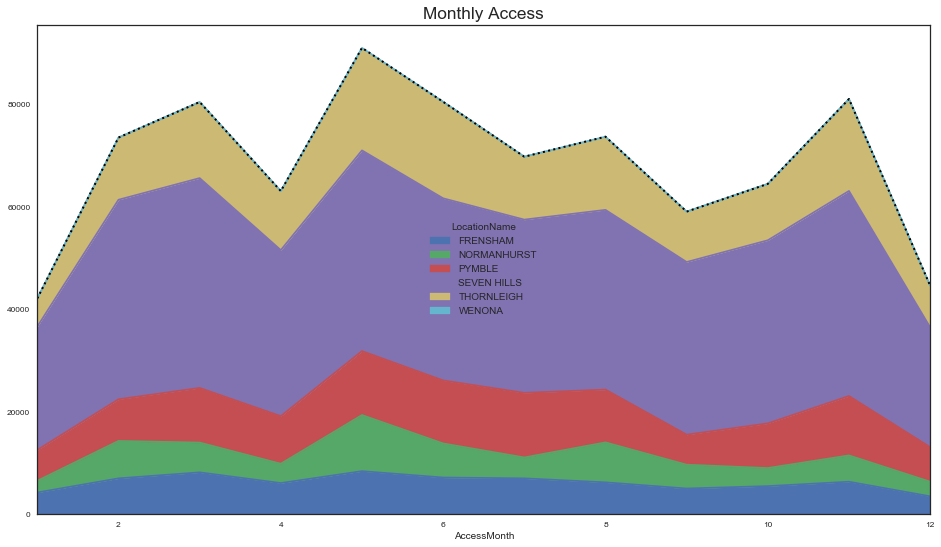

In [298]:
# Monthly grouping

Monthly = pd.pivot_table(DF, index='AccessMonth', columns='LocationName', 
                         values='IsGuestPass', aggfunc='count',fill_value=0)

Monthly.plot.area(figsize=(16,9), title='Monthly Access')

DF.groupby(('AccessMonth')).IsGuestPass.count().plot(c='black',lw=2, ls=':')

In [306]:
Monthly.T.sum().describe()

count       12.000000
mean     68536.833333
std      14787.150711
min      42048.000000
25%      61994.750000
50%      71572.000000
75%      80389.500000
max      90948.000000
dtype: float64

---
# YEARLY
---

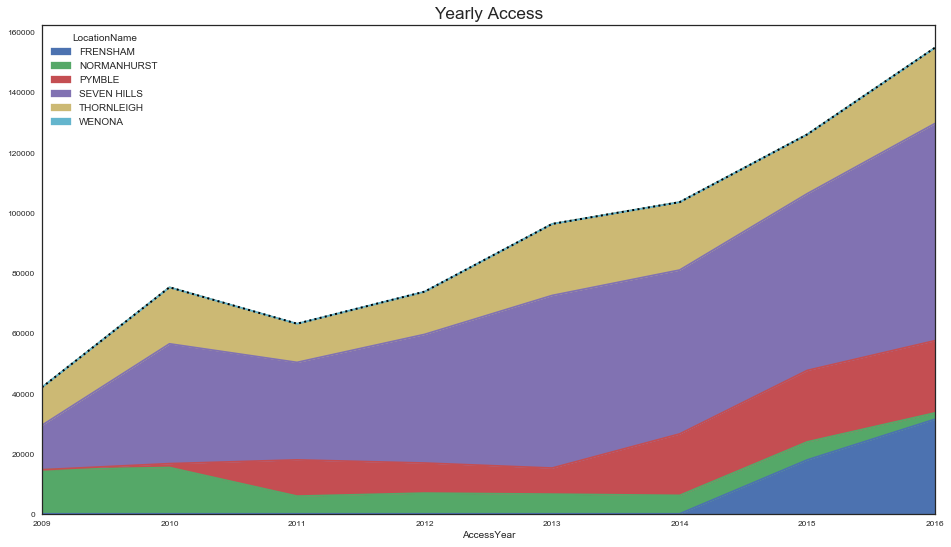

In [322]:
# Yearly grouping

Yearly = pd.pivot_table(DF[DF.AccessYear < 2017], index='AccessYear', columns='LocationName', 
                        values='IsGuestPass', aggfunc='count',fill_value=0)

Yearly.plot.area(figsize=(16,9), title='Yearly Access')

DF[DF.AccessYear < 2017].groupby(('AccessYear')).IsGuestPass.count().plot(c='black',lw=2, ls=':')

In [323]:
Yearly.pct_change().fillna(0)

LocationName,FRENSHAM,NORMANHURST,PYMBLE,SEVEN HILLS,THORNLEIGH,WENONA
AccessYear,,,,,,
2009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010,0.000000,0.050000,inf,1.694042,0.489249,0.000000
2011,0.000000,-0.618072,8.301391,-0.186173,-0.320635,inf
2012,0.000000,0.170669,-0.169990,0.319365,0.097404,1.115789
2013,0.000000,-0.050196,-0.132132,0.341556,0.697635,-1.000000
2014,0.000000,-0.063113,1.354095,-0.050351,-0.050516,0.000000
2015,inf,-0.022564,0.163253,0.078428,-0.127466,0.000000
2016,0.753506,-0.647708,0.010530,0.228480,0.278150,0.000000


---
# DAILY ENTRIES
---

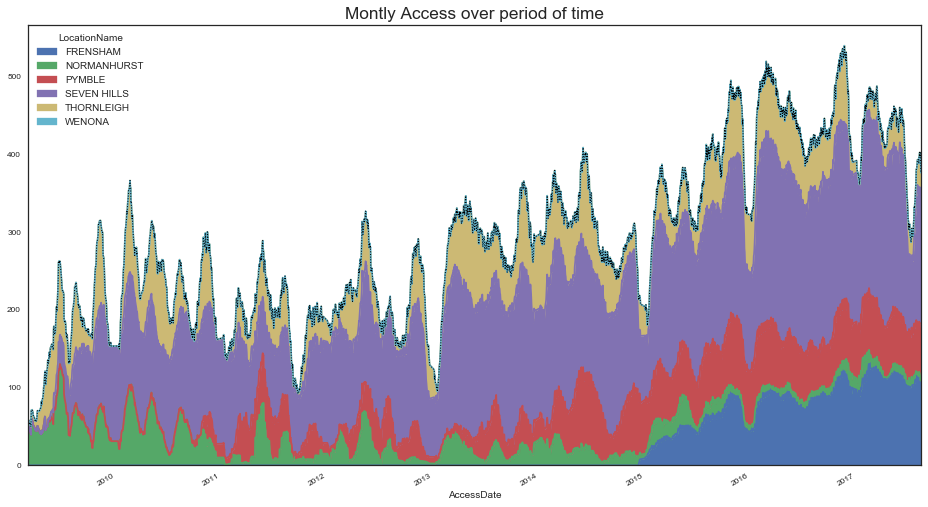

In [63]:
# Date Timeseries grouping

Access_by_Site = pd.pivot_table(DF, index='AccessDate', 
                                columns='LocationName',
                                values='IsGuestPass', 
                                aggfunc='count',fill_value=0)


Access_by_Site.rolling(window=30,min_periods=1,center=True).mean().plot.area(figsize=(16,9),
                                                                            title='Montly Access over period of time')

DF.groupby(('AccessDate')).IsGuestPass.count().rolling(window=30,min_periods=1,center=True).mean().plot(c='black',lw=1, ls=':')

# Aquabliss Customers Location and Frequency

### Customers:

In [5]:
Cutomers = pd.concat([pd.read_sql('select * from People, AccessPointEntries where People.Id = AccessPointEntries.PeopleId', 
                                con=connection1).groupby(['PeopleId'])['IsGuestPass'].count(),
                    pd.read_sql('select * from People, AccessPointEntries where People.Id = AccessPointEntries.PeopleId', 
                                con=connection2).groupby(['PeopleId'])['IsGuestPass'].count(),
                    pd.read_sql('select * from People, AccessPointEntries where People.Id = AccessPointEntries.PeopleId', 
                                con=connection3).groupby(['PeopleId'])['IsGuestPass'].count()
                   ])

Cutomers.describe()

count    23265.000000
mean        35.468214
std         43.501642
min          1.000000
25%          6.000000
50%         19.000000
75%         49.000000
max        550.000000
Name: IsGuestPass, dtype: float64

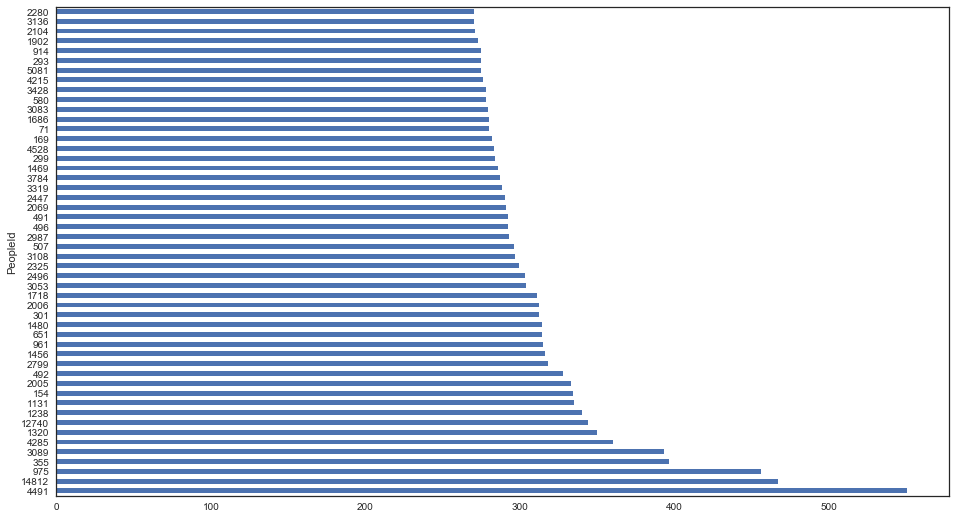

In [307]:
Cutomers.sort_values(ascending=False).head(50).plot.barh(figsize=(16,9))

In [17]:
Cutomers.sort_values(ascending=False).head(10).index

Int64Index([4491, 14812, 975, 355, 3089, 4285, 1320, 12740, 1238, 1131], dtype='int64', name=u'PeopleId')

In [328]:
# Checking what kind of customer
pd.read_sql('select * from People where Id = 4491', con=connection1)

,Id,_New,Surname,GivenNames,Title,DateOfBirth,Gender,Address,Suburb,PostCode,...,ReferredBy,PartnerName,State,WebPassword,WebUserId,WebRegistered,QASBarCode,CreationMethod,ActiveCarrotEnabled,ReferenceNumber
0,4491,,(redacted),(redacted),MRS,None,F,(redacted),,,...,0,,,0,,0,,1,None,


In [356]:
DF[DF.PeopleId == 4491][['IsStaff','PeopleId', 'StudentOutOfHoursId', 'AccessProfileId','AccessReason']].head(1)

,IsStaff,PeopleId,StudentOutOfHoursId,AccessProfileId,AccessReason
64860,0,4491,0,0,Access


### Visualizing all Cutomers

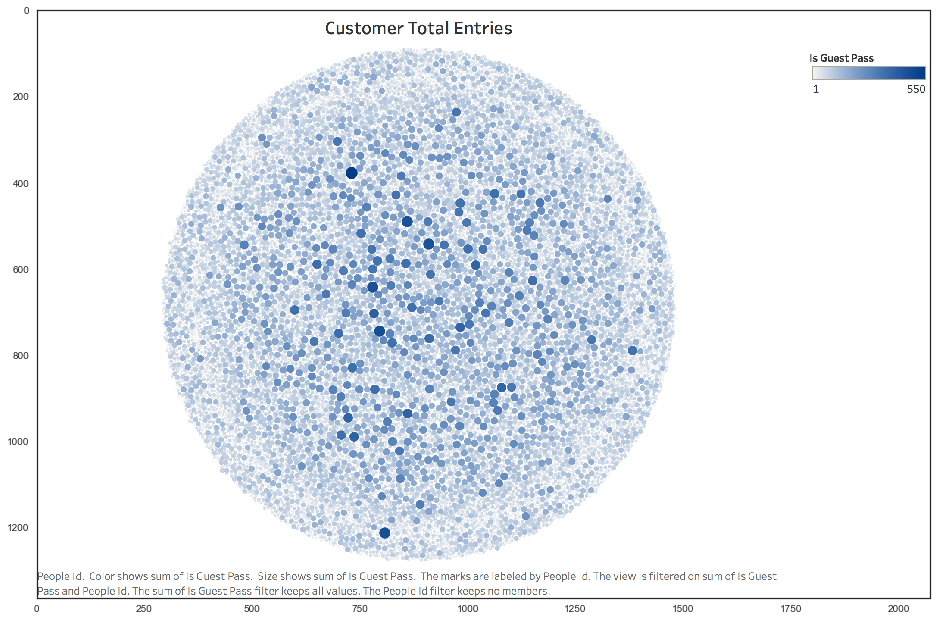

In [404]:
image = img.imread('Datasets/Customer Total Entries.png')

plt.figure(figsize = (16,16))

plt.imshow(image)

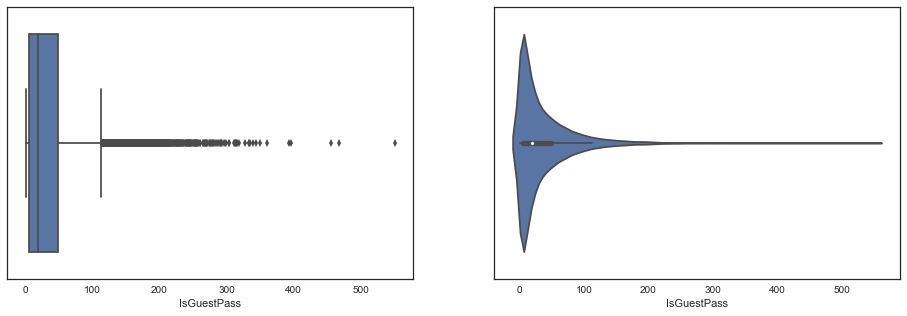

In [225]:
fig,ax = plt.subplots(1,2, figsize=(16,5))

sns.boxplot(Cutomers, ax=ax[0])
sns.violinplot(Cutomers, ax=ax[1])

### Suburbs:

In [247]:
Suburbs = pd.concat([pd.read_sql('select * from people', con=connection1),
                     pd.read_sql('select * from people', con=connection2),
                     pd.read_sql('select * from people', con=connection3),
                   ]).groupby(['PostCode'])['Id'].count()

Suburbs.drop(Suburbs.index[:1], inplace=True) #deleting the over 4000 without Suburbs

Suburbs.describe()

count     216.000000
mean      194.694444
std       676.927442
min         1.000000
25%         2.000000
50%         4.000000
75%        45.250000
max      4799.000000
Name: Id, dtype: float64

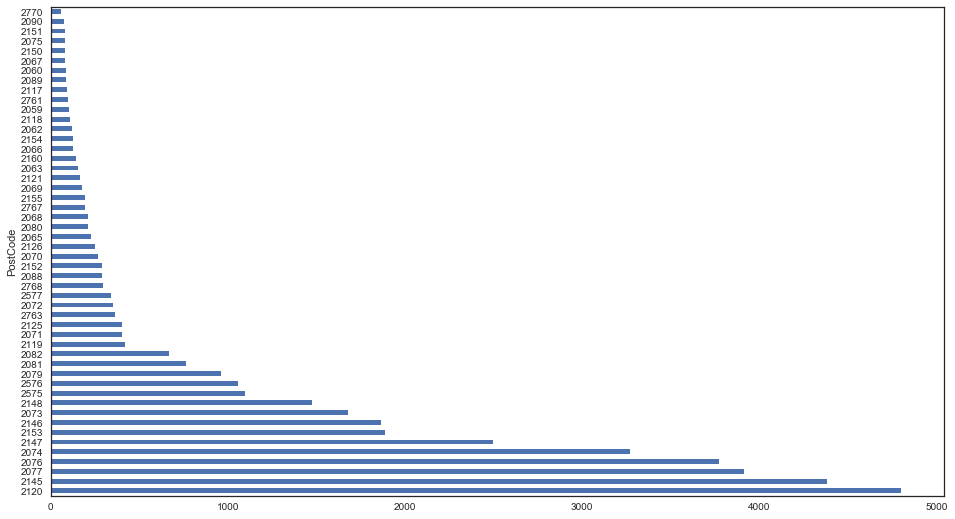

In [248]:
Suburbs.sort_values(ascending=False).head(50).plot.barh(figsize=(16,9))

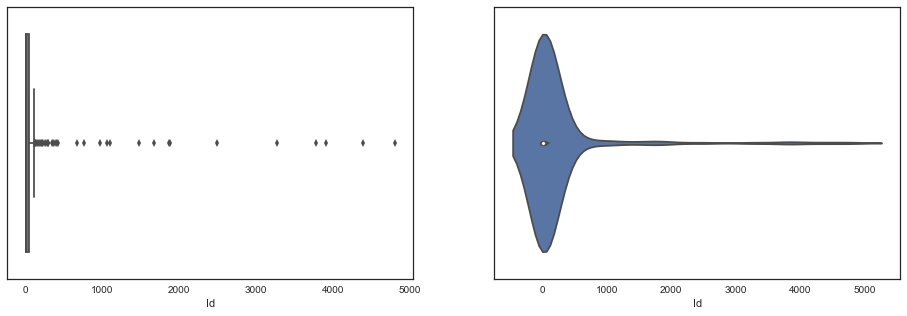

In [249]:
fig,ax = plt.subplots(1,2, figsize=(16,5))

sns.boxplot(Suburbs, ax=ax[0])
sns.violinplot(Suburbs, ax=ax[1])

### Recovering the Longitude and Latitude of adresses

In [400]:
#function that recover the Longitude and Latitude of adresses

def get_coord(x):
    
    x = x + ', NSW'
    retry = 0
    while retry < 3:
        geolocator = Nominatim()
        try:
            location = geolocator.geocode(x)
            return (location.latitude, location.longitude)
        except:
            #return np.nan
            retry = retry+1
            time.sleep(1)
    return np.nan

In [398]:

time.sleep(5)

### Addresses:

In [402]:
#Addresses

Addresses['Latitude&Longitude'] = Addresses.PostCode.apply(lambda x: get_coord(x))

Addresses['Latitude'] = Addresses['Latitude&Longitude'].map(lambda x: x[0])
Addresses['Longitude'] = Addresses['Latitude&Longitude'].map(lambda x: x[1])

Addresses

,LocationName,LocationAddress,PostCode,Latitude&Longitude,Latitude,Longitude
0,THORNLEIGH,"17 Sefton Road, Thornleigh NSW",2120,"(-33.7305959086, 151.078072892)",-33.730596,151.078073
1,WERRINGTON,"Unit 2/1 Lavin Crescent, Werrington County NSW",2747,"(-33.7511439848, 150.735186372)",-33.751144,150.735186
2,ROSEVILLE,"27 Bancroft Avenue, Roseville NSW",2069,"(-33.7811775905, 151.193201763)",-33.781178,151.193202
3,GREGORY HILLS,"67-77 Lasso Road, Gregory Hills NSW",2069,"(-33.7811775905, 151.193201763)",-33.781178,151.193202
4,WENONA,"201-203 Walker Street, North Sydney NSW",2060,"(-33.8401005, 151.211526451)",-33.840100,151.211526
5,NORMANHURST,"91-93 Pennant Hills Road, Normanhurst NSW",2076,"(-33.7123540413, 151.117498192)",-33.712354,151.117498
6,PYMBLE,"1 Bobbin Head Road, Pymble NSW",2073,"(-33.7508326762, 151.133179157)",-33.750833,151.133179
7,SEVEN HILLS,"20 Distribution Place, Seven Hills NSW",2575,"(-34.3962389654, 150.410455447)",-34.396239,150.410455
8,FRENSHAM,"Range Road, Mittagong NSW",2575,"(-34.3962389654, 150.410455447)",-34.396239,150.410455


# Customer geolacalization:

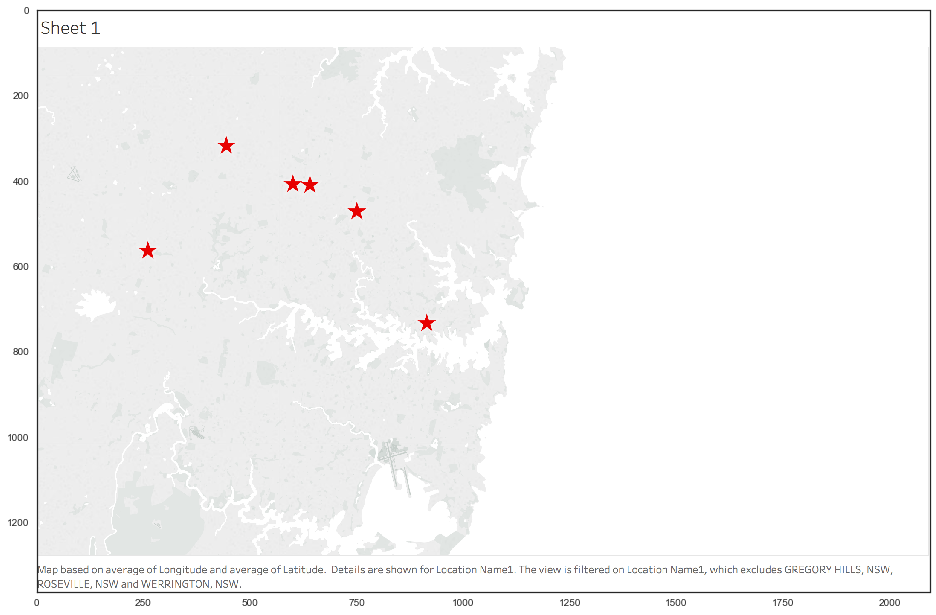

In [352]:
image = img.imread('Datasets/Adresses.png')

plt.figure(figsize = (16,12))

plt.imshow(image)

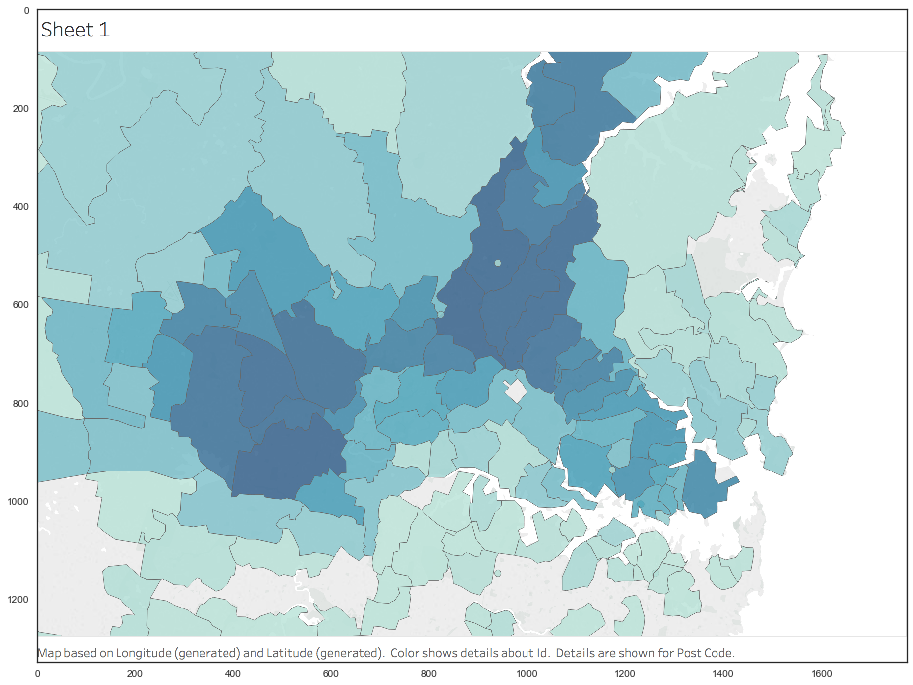

In [410]:
image = img.imread('Datasets/Suburbs2.png')

plt.figure(figsize = (16,12))

plt.imshow(image)#,extent=(-33, -34.2, 150.8, 151.5))


#plt.scatter(list(Addresses.Latitude), list(Addresses.Longitude), marker='x', color='r',s=200)

#plt.scatter([-33.7123540413,-33.8401005],[151.117498192,],marker='x',color='r',s=200)

In [ ]:
STOP !!

# Externalize

In [405]:
DF.to_csv('Datasets/DF.csv')
 
Access_by_Site['TOTAL'] = Access_by_Site['FRENSHAM'] + Access_by_Site['NORMANHURST'] + Access_by_Site['PYMBLE'] + Access_by_Site['SEVEN HILLS'] + Access_by_Site['THORNLEIGH'] + Access_by_Site['WENONA']
Access_by_Site.to_csv('Datasets/Access_by_Site.csv')

Addresses.to_csv('Datasets/Addresses.csv')

Suburbs.reset_index().to_csv('Datasets/Suburbs.csv')

Cutomers.reset_index().to_csv('Datasets/Customers.csv')


In [284]:
Suburbs.to_csv('Datasets/Suburbs.csv')



In [283]:
Suburbs = pd.concat([Suburbs.reset_index(), Addresses[['PostCode','Id']]])

In [275]:
Addresses['Id'] = 10000
Addresses[['PostCode','Id']]

,PostCode,Id
0,2120,10000
1,2747,10000
2,2069,10000
3,2069,10000
4,2060,10000
5,2076,10000
6,2073,10000
7,2575,10000
8,2575,10000
